# **DATA COLLECTION**

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from datetime import datetime
from scipy.stats import zscore

### Load 1hr tf data

In [2]:
file_path = '/home/cyberpunk/Trading_bot_v1.0/Data/Raw/GOLD--ALL--TFS/XAU_1h_data_2004_to_2024-09-20.csv'

In [3]:
df = pd.read_csv(file_path)

print(df.head(10))

         Date   Time   Open   High    Low  Close  Volume
0  2004.06.11  07:00  384.0  384.3  383.3  383.8      44
1  2004.06.11  08:00  383.8  384.3  383.1  383.1      41
2  2004.06.11  09:00  383.1  384.1  382.8  383.1      55
3  2004.06.11  10:00  383.0  383.8  383.0  383.6      33
4  2004.06.11  11:00  383.6  383.8  383.5  383.6      23
5  2004.06.11  12:00  383.5  384.1  383.3  383.3      20
6  2004.06.11  13:00  383.6  384.3  383.6  384.0      15
7  2004.06.11  14:00  383.8  383.8  383.8  383.8       4
8  2004.06.11  15:00  383.8  384.6  383.8  384.6       9
9  2004.06.11  16:00  384.3  384.8  384.1  384.3      19


# **DATA PRE-PROCESSING**

In [4]:
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), format='%Y.%m.%d %H:%M')

df.drop(columns=['Date', 'Time'], inplace=True)

df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)
df['Volume'] = df['Volume'].astype(int)

df.set_index('Datetime', inplace=True)

In [5]:
print(df.head(10))

                      Open   High    Low  Close  Volume
Datetime                                               
2004-06-11 07:00:00  384.0  384.3  383.3  383.8      44
2004-06-11 08:00:00  383.8  384.3  383.1  383.1      41
2004-06-11 09:00:00  383.1  384.1  382.8  383.1      55
2004-06-11 10:00:00  383.0  383.8  383.0  383.6      33
2004-06-11 11:00:00  383.6  383.8  383.5  383.6      23
2004-06-11 12:00:00  383.5  384.1  383.3  383.3      20
2004-06-11 13:00:00  383.6  384.3  383.6  384.0      15
2004-06-11 14:00:00  383.8  383.8  383.8  383.8       4
2004-06-11 15:00:00  383.8  384.6  383.8  384.6       9
2004-06-11 16:00:00  384.3  384.8  384.1  384.3      19


### Check for missing values

In [6]:
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [7]:
print(df.dtypes)

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [8]:
# Check for duplicate rows
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for time gaps
df['Time_Diff'] = df.index.to_series().diff().dt.total_seconds() / 3600  # Difference in hours
print(f"Max gap: {df['Time_Diff'].max()} hours")

# Drop duplicates if found
df = df[~df.duplicated()]

Duplicate rows: 41
Max gap: 109.0 hours


In [9]:
# Detect outliers in price columns
z_scores = zscore(df[['Open', 'High', 'Low', 'Close']])
outliers = (np.abs(z_scores) > 3).any(axis=1)

print(f"Outliers detected: {outliers.sum()}")
# Optional: Remove outliers
df = df[~outliers]

Outliers detected: 0


In [10]:
# Check the frequency of the data
print(f"Current data frequency: {df.index.inferred_freq}")

# Check the number of unique time intervals in the data
print(f"Number of unique time intervals: {df.index.to_series().diff().nunique()}")

Current data frequency: None
Number of unique time intervals: 46


### Resampling to 1h since the current data frequency is not consistent
Using linear interpolation for a live trading model; Because it fills in missing values based on the surrounding data points, 
making it more realistic than forward filling.

In [11]:
# Ensure the datetime index is sorted before resampling
df = df.sort_index()

# Resample to hourly frequency and interpolate missing values
df_resampled = df.resample('H').interpolate(method='linear')

# Explicitly set the frequency to hourly
df_resampled.index = pd.date_range(start=df_resampled.index.min(), 
                                   end=df_resampled.index.max(), 
                                   freq='H')

# Verify the frequency and intervals again
print(f"Current data frequency: {df_resampled.index.inferred_freq}")
print(f"Number of unique time intervals: {df_resampled.index.to_series().diff().nunique()}")

Current data frequency: h
Number of unique time intervals: 1


/tmp/ipykernel_10499/840673816.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('H').interpolate(method='linear')
/tmp/ipykernel_10499/840673816.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled.index = pd.date_range(start=df_resampled.index.min(),


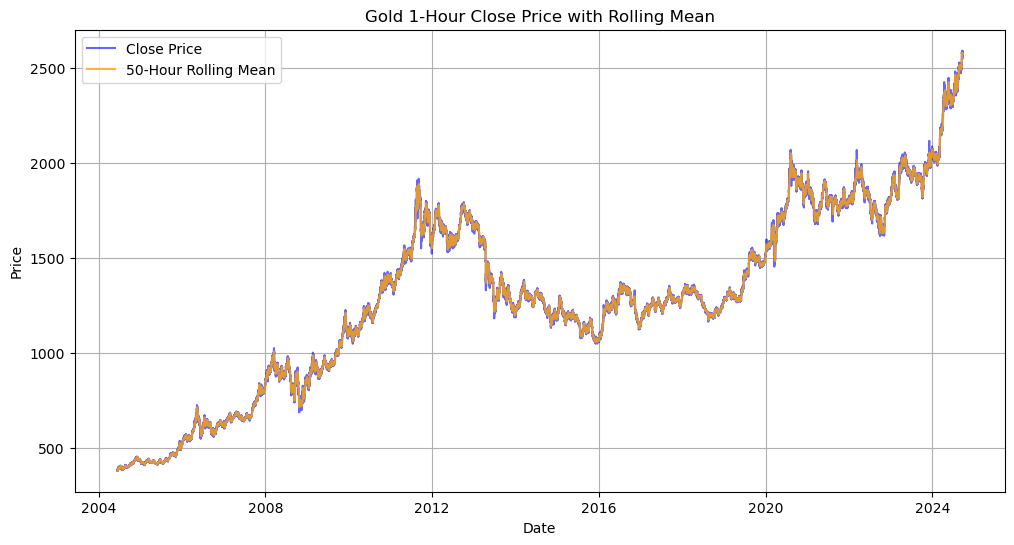

In [12]:
# Add rolling averages
df['Rolling_Mean_Close'] = df['Close'].rolling(window=50).mean()

# Plot with rolling averages
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df['Rolling_Mean_Close'], label='50-Hour Rolling Mean', color='orange', alpha=0.8)
plt.title('Gold 1-Hour Close Price with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Gold 1-Hour Close Price Visualization

This chart represents the hourly closing prices of gold (XAU/USD) over the period from 2004 to 2024. The data points indicate the fluctuations in the market price for each hour. Observing such a plot is useful for identifying trends, patterns, and potential points of resistance or support.

- **X-axis**: Time (dates and hours)
- **Y-axis**: Price in USD

Trends, like upward or downward movements, are visible, and the overall volatility can be assessed. A trader may use such visualizations to identify price movements and predict future price directions.

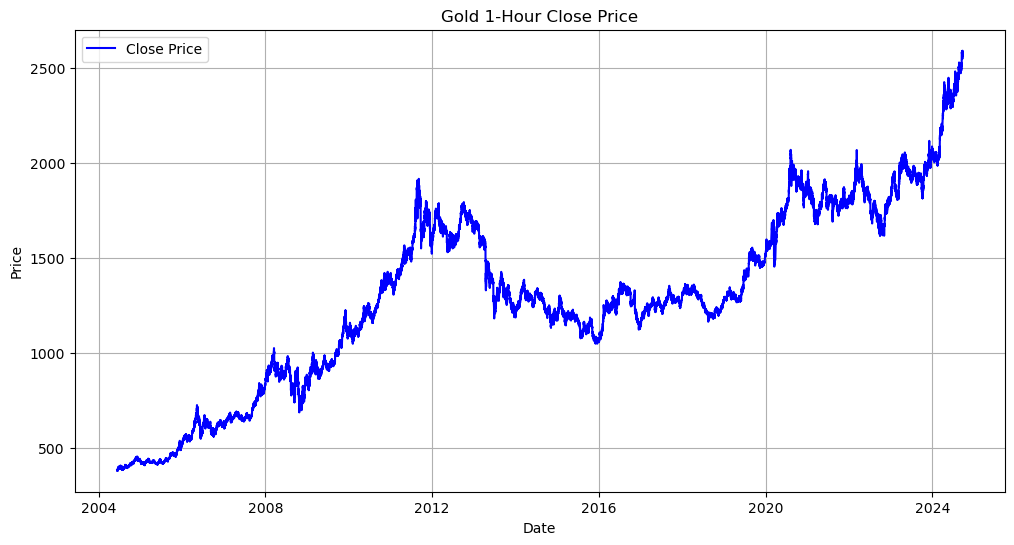

In [13]:
import matplotlib.pyplot as plt

# Plot the 'Close' price
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Close'], label='Close Price', color='blue')
plt.title('Gold 1-Hour Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **TODO - TOO MUCH SPIKES(OUTLIERS/NEWS EVENTS)-5938-1-VOLUME**
### Gold 1-Hour Trading Volume Visualization

This chart visualizes the hourly trading volume of gold (XAU/USD) from 2004 to 2024. Volume refers to the number of units traded in a given time frame, and it is a critical indicator of market activity.

- **X-axis**: Time (dates and hours)
- **Y-axis**: Trading Volume

Volume spikes are noticeable in certain periods, indicating higher market activity. Traders often look for volume surges as an indicator of price action and potential market moves.

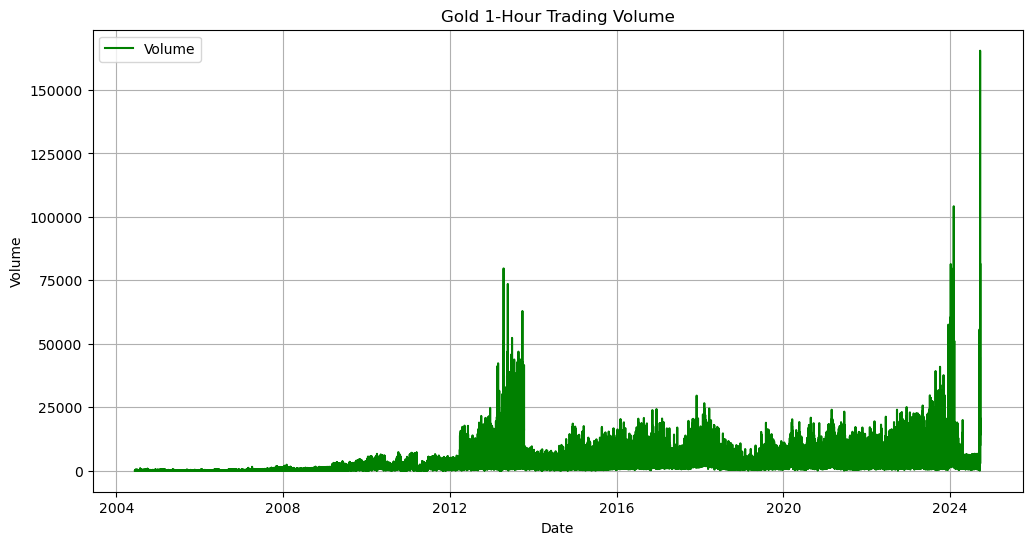

In [14]:
# Plot the 'Volume' data
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Volume'], label='Volume', color='green')
plt.title('Gold 1-Hour Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Calculate the IQR (Interquartile Range) for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identify the outliers using IQR (values outside the range: Q1 - 1.5*IQR, Q3 + 1.5*IQR)
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))

# Display the number of outliers for each column
outliers_count = outliers.sum()
print(f"Outliers detected in each column:\n{outliers_count}")

# Optionally, display the outlier values for further inspection (example for 'Close')
print("\nOutlier values in the 'Close' column:")
print(df[outliers['Close']])

Outliers detected in each column:
Open                     0
High                     0
Low                      0
Close                    0
Volume                5937
Time_Diff             5273
Rolling_Mean_Close       0
dtype: int64

Outlier values in the 'Close' column:
Empty DataFrame
Columns: [Open, High, Low, Close, Volume, Time_Diff, Rolling_Mean_Close]
Index: []


In [16]:
#from scipy.stats import zscore
# Calculate Z-scores for the volume data
df_resampled['Volume_Zscore'] = zscore(df_resampled['Volume'])

# Set a threshold for detecting significant outliers
threshold = 3  # You can adjust this threshold
outliers = df_resampled[df_resampled['Volume_Zscore'].abs() > threshold]

# Print out the dates and corresponding volume spikes
print(outliers[['Volume_Zscore', 'Volume']])

                     Volume_Zscore   Volume
2012-03-29 18:00:00       3.175386  13882.0
2012-04-02 17:00:00       3.100866  13618.0
2012-04-03 16:00:00       3.201638  13975.0
2012-04-03 17:00:00       3.420964  14752.0
2012-04-03 21:00:00       3.213775  14018.0
...                            ...      ...
2024-09-19 18:00:00      10.589860  40149.0
2024-09-19 19:00:00       7.087412  27741.0
2024-09-19 20:00:00       4.347103  18033.0
2024-09-19 21:00:00       4.186489  17464.0
2024-09-19 22:00:00       3.363098  14547.0

[3057 rows x 2 columns]


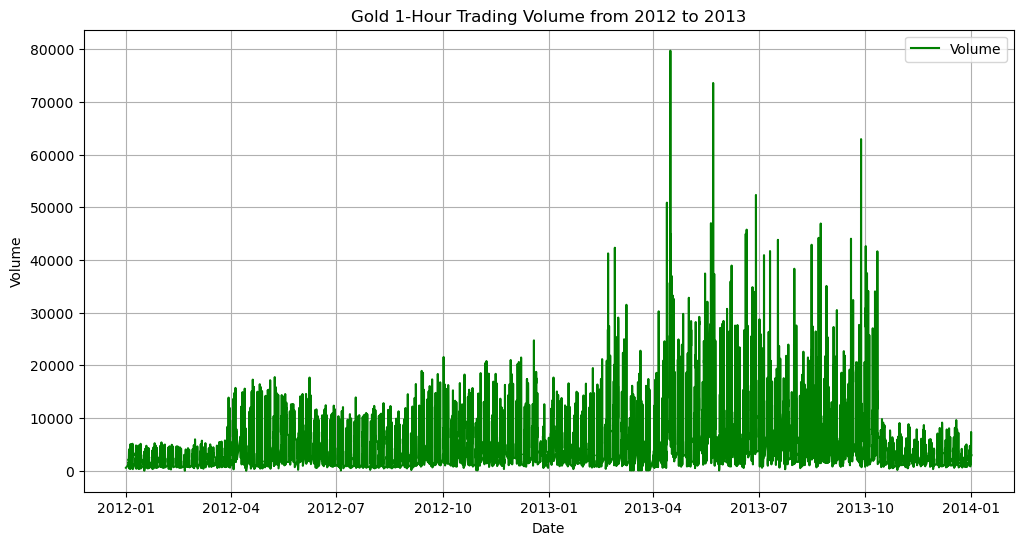

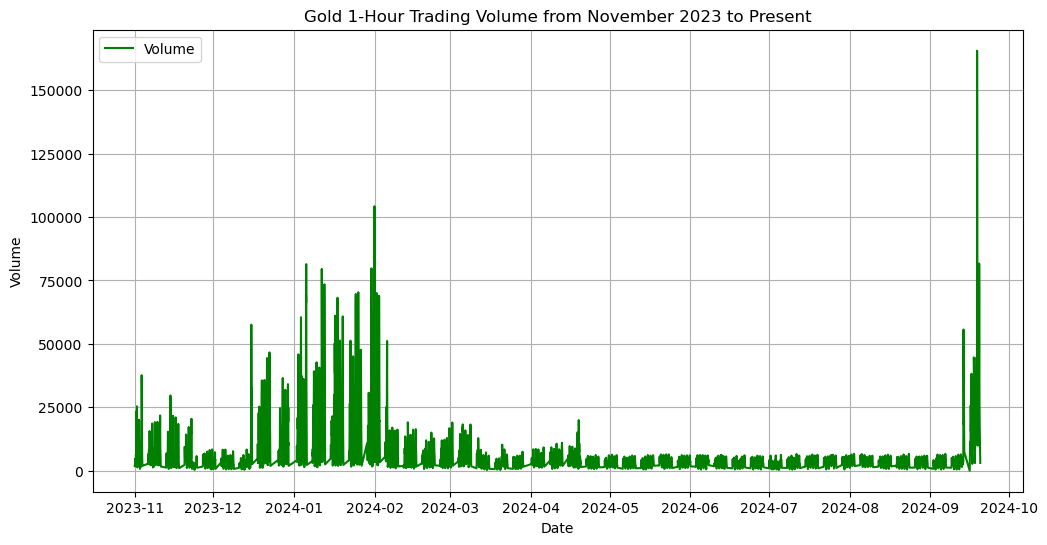

In [17]:
# Zoom into specific time periods: 2012-2013 and 2023-11 to the present
df_2012_2013 = df_resampled.loc['2012-01-01':'2013-12-31']
df_2023_11_to_now = df_resampled.loc['2023-11-01':]

# Plot for 2012-2013 period
plt.figure(figsize=(12, 6))
plt.plot(df_2012_2013.index, df_2012_2013['Volume'], label='Volume', color='green')
plt.title('Gold 1-Hour Trading Volume from 2012 to 2013')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Plot for 2023-11 to present
plt.figure(figsize=(12, 6))
plt.plot(df_2023_11_to_now.index, df_2023_11_to_now['Volume'], label='Volume', color='green')
plt.title('Gold 1-Hour Trading Volume from November 2023 to Present')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### Gold 1-Hour Opening Price Visualization

This chart shows the opening price of gold (XAU/USD) on an hourly basis from 2004 to 2024. The opening price is the price at which the first trade occurs in each time period.

- **X-axis**: Time (dates and hours)
- **Y-axis**: Opening Price (USD)

The chart highlights fluctuations in the opening price of gold, which can provide insights into market trends and investor sentiment at the start of each trading hour.

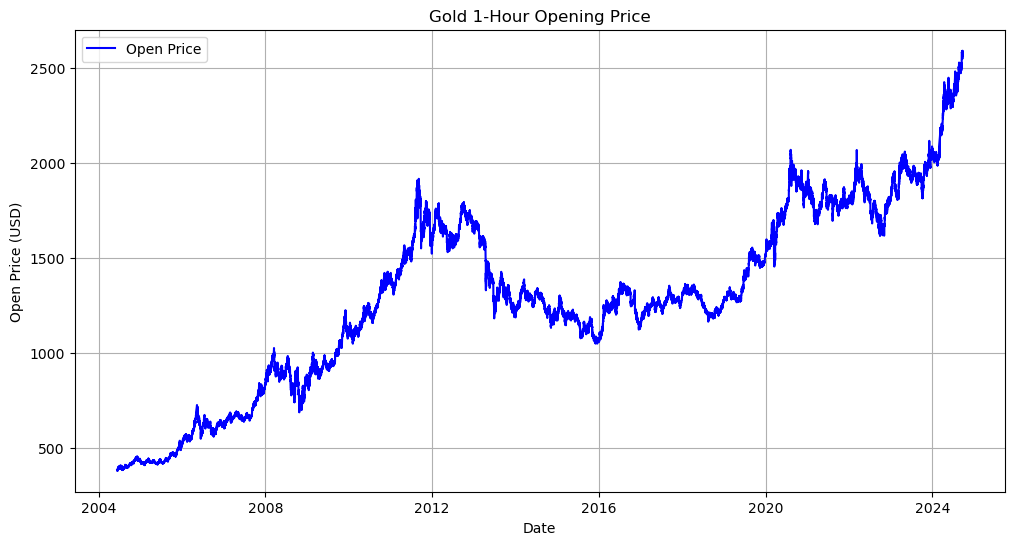

In [18]:
# Plot the 'Open' price data
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Open'], label='Open Price', color='blue')
plt.title('Gold 1-Hour Opening Price')
plt.xlabel('Date')
plt.ylabel('Open Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Gold 1-Hour High Price Visualization

This chart illustrates the highest price of gold (XAU/USD) during each hour of trading from 2004 to 2024. The high price represents the peak value that gold reached during the specified time period.

- **X-axis**: Time (dates and hours)
- **Y-axis**: High Price (USD)

Observing the high price can help identify volatility and market peaks, which may offer insights into trading opportunities or periods of increased market activity.

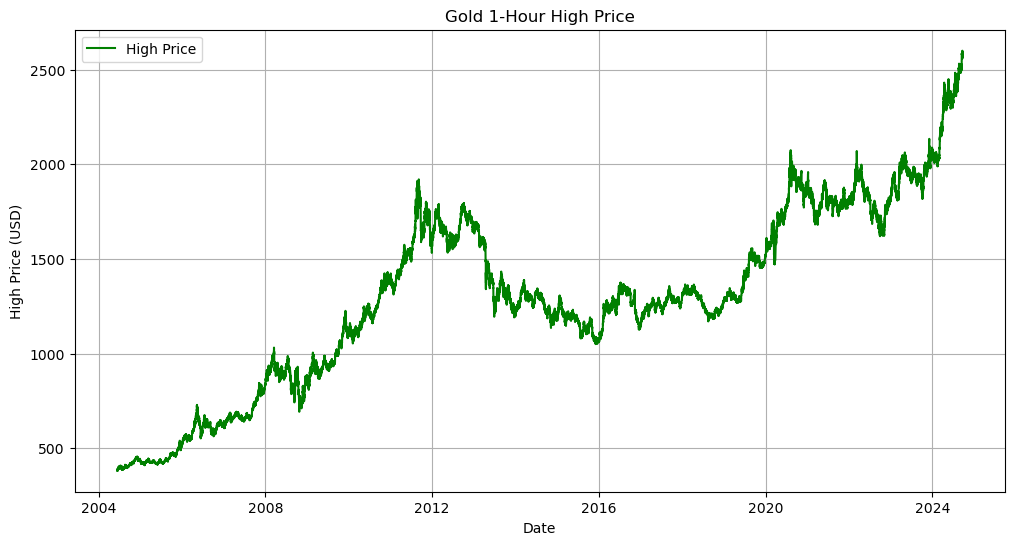

In [19]:
# Plot the 'High' price data
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['High'], label='High Price', color='green')
plt.title('Gold 1-Hour High Price')
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Gold 1-Hour Low Price Visualization

This chart displays the lowest price of gold (XAU/USD) for each hourly trading session from 2004 to 2024. The low price indicates the bottom price reached during the specified time period.

- **X-axis**: Time (dates and hours)
- **Y-axis**: Low Price (USD)

By examining the low price trends, traders can understand market dips and assess potential entry points when prices drop to key support levels.

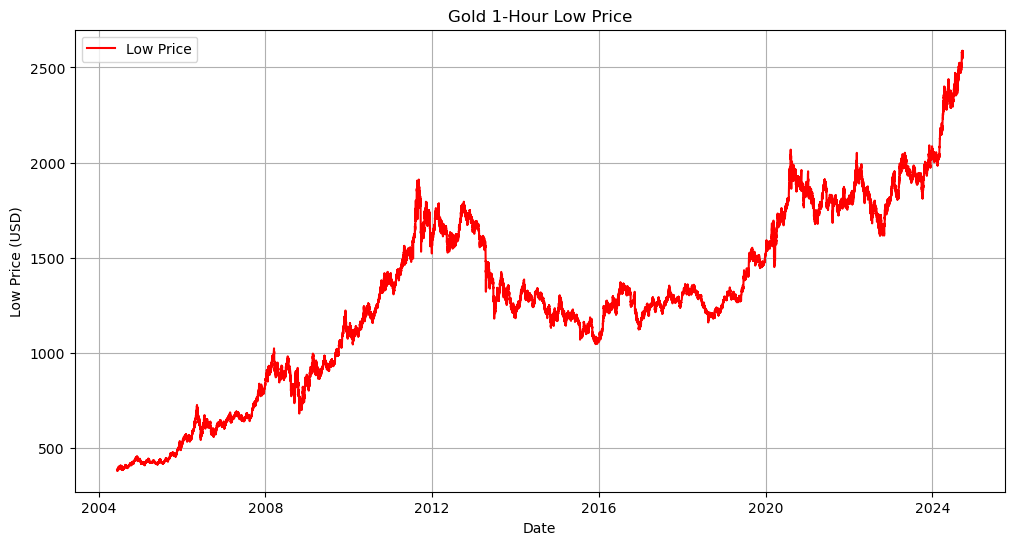

In [20]:
# Plot the 'Low' price data
plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Low'], label='Low Price', color='red')
plt.title('Gold 1-Hour Low Price')
plt.xlabel('Date')
plt.ylabel('Low Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 50-Period Rolling Average of XAU/USD 1-Hour Close Price
This chart visualizes the 1-hour closing price of XAU/USD along with its 50-period rolling average. The rolling average helps to smooth out short-term price fluctuations, making it easier to identify the overall trend. Traders often use moving averages as an indicator of market direction, with price crossing above or below the average potentially signaling buy or sell opportunities. The chart provides a clearer view of the long-term trend and can help in identifying when the price is either trending upwards, downwards, or consolidating.



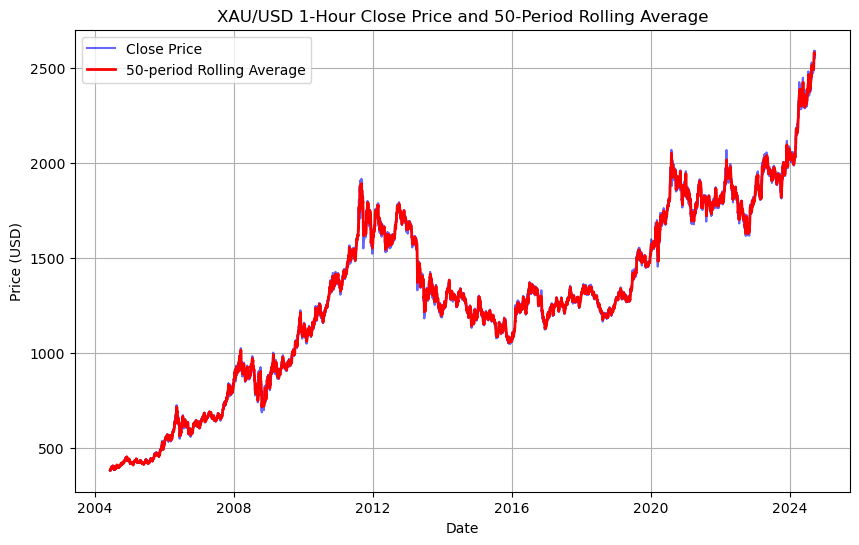

In [21]:
# Plot a 50-period rolling average for the Close price
df_resampled['50_rolling_avg'] = df_resampled['Close'].rolling(window=50).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_resampled.index, df_resampled['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df_resampled.index, df_resampled['50_rolling_avg'], label='50-period Rolling Average', color='red', linewidth=2)
plt.title('XAU/USD 1-Hour Close Price and 50-Period Rolling Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [22]:
# Display the first few rows to check
df.head()

,Open,High,Low,Close,Volume,Time_Diff,Rolling_Mean_Close
Datetime,,,,,,,
2004-06-11 07:00:00,384.0,384.3,383.3,383.8,44,NaN,NaN
2004-06-11 08:00:00,383.8,384.3,383.1,383.1,41,1.0,NaN
2004-06-11 09:00:00,383.1,384.1,382.8,383.1,55,1.0,NaN
2004-06-11 10:00:00,383.0,383.8,383.0,383.6,33,1.0,NaN
2004-06-11 11:00:00,383.6,383.8,383.5,383.6,23,1.0,NaN


### Save preprocessed data

In [23]:
import os

# Define the absolute path for saving preprocessed data
preprocessed_file_path = "/home/cyberpunk/Trading_bot_v1.0/Data/Preprocessed/XAU_1h_preprocessed_2004_to_2024.csv" #replace /Users/mac/Desktop/ML_Trading_Bot with your project path

# Save the preprocessed data
df_resampled.to_csv(preprocessed_file_path, index=True)

print(f"Preprocessed data saved to: {preprocessed_file_path}")

Preprocessed data saved to: /home/cyberpunk/Trading_bot_v1.0/Data/Preprocessed/XAU_1h_preprocessed_2004_to_2024.csv
